In [87]:
#importing all the necessay libraries

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [59]:
#Custom data class inheriting from Dataset

class PneumoniaDataset(Dataset):
    
    def __init__(self, datadir, transform=None):
        self.datadir = datadir
        self.transform = transform
        self.normal = os.listdir(datadir + "/NORMAL")
        self.pneumonia = os.listdir(datadir + "/PNEUMONIA")
        
    def __len__(self): #returns total number of image in the dataset
        return len(self.normal) + len(self.pneumonia)
    
    #retrives specific image and its class
    def __getitem__(self, idx): 
        if idx < len(self.normal):
            path = self.datadir + "/NORMAL/" + self.normal[idx]
            y = 0
        else:
            path = self.datadir + "/PNEUMONIA/" + self.pneumonia[idx - len(self.normal)]
            y = 1
            
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        if transform:
            image = self.transform(image)
            
        return image, y

In [62]:
transform = transforms.Compose([transforms.ToTensor()])
datadir = '/Users/velmurugan/Desktop/@/python_works/Pneumonia_detection/chest_xray'

trainset = PneumoniaDataset(datadir + "/train", transform=transform)
testset = PneumoniaDataset(datadir + "/test", transform=transform)
valset = PneumoniaDataset(datadir + "/val", transform=transform)

print(f'Number of images in the trainset {trainset.__len__()}')

batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

print("Length of Train Loader",len(trainloader))
print("Length of Test Loader",len(testloader))
print("Length of Val Loader", len(valloader))

Number of images in the trainset 5216
Length of Train Loader 326
Length of Test Loader 39
Length of Val Loader 1


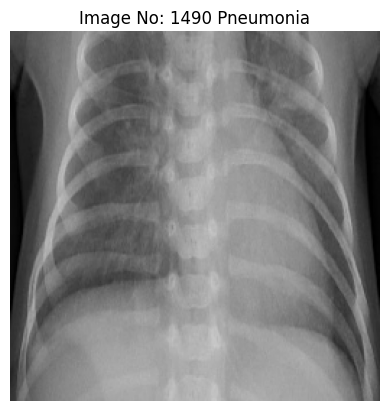

In [68]:
random_img = np.random.randint(1,5217)

image, label = trainset[random_img]
classes = {0: "Normal", 1: "Pneumonia"}
plt.imshow(image.permute(1, 2, 0))
plt.title('Image No: '+str(random_img)+' '+classes[label])
plt.axis('off')
plt.show()

In [38]:
#CNN architecture

class PneumoniaClassifier(nn.Module):
    
    def __init__(self):
        super(PneumoniaClassifier, self).__init__()
        self.cnn = nn.Sequential(                                   #Input image is 3x256x256
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),   #image is 16x128x128
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 16x64x64
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  #image is 32x32x32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 32x16x16
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  #image is 64x8x8
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2, padding=0),                   #image is 64x4x4
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #image is 128x2x2
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2),
        )
    
    def forward(self, x):
        return self.cnn(x)

In [56]:
#Calculate  the total number of trainable parameters

model = PneumoniaClassifier()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {total_params} trainable parameters")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

The model has 130882 trainable parameters


In [70]:
#Train the model for 5 epochs

model.train()

for epoch in range(5):
    
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%300 == 0 :    # print every 300th mini-batch
            print(f'Epoch: {epoch + 1}, loss: {loss:.5f}')

print('Finished Training')


Epoch: 1, loss: 0.03301
Epoch: 2, loss: 0.00115
Epoch: 3, loss: 0.00091
Epoch: 4, loss: 0.00341
Epoch: 5, loss: 0.00770
Finished Training


In [82]:
#Evaluate the model on the test set

correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the {total} test images: {(100 * (correct / total)):.2f} %')

Accuracy of the model on the 624 test images: 75.80 %


In [78]:
torch.max(outputs.data,1)

torch.return_types.max(
values=tensor([ 9.2347,  6.3752,  8.3097,  8.2533,  7.7055,  9.0577,  6.0015,  6.5472,
         7.1367,  5.9639,  4.0352,  8.5174,  8.0553,  8.1634, 10.0460,  7.9604]),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [86]:
predicted

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [88]:
#save the trained model

model_path = '/Users/velmurugan/Desktop/@/python_works/Pneumonia_detection/trained.pkl'

with open(model_path,'wb') as f:
    pickle.dump(model,f)

In [89]:
#load the saved model

with open(model_path,'rb') as f:
    loaded_model = pickle.load(f)

In [91]:
print(f'Number of images in the Validation set {valset.__len__()}')

Number of images in the Validation set 16


In [108]:
# evaluating the loaded model
random_img = np.random.randint(0,len(valset))
image, label = valset[random_img]
image = image.unsqueeze(0)


if label == 0:
    print("Actual is Normal")
else:
    print('Actual is Pneumonia')

pred = loaded_model(image)
print(pred)
_,pred = torch.max(pred,1)

if pred == 0:
    print("Predicted is Normal")
else:
    print("Predicted is Pneumonia")



Actual is Normal
tensor([[ 0.7849, -1.2889]], grad_fn=<AddmmBackward0>)
Predicted is Normal
